Author: Frauke Albrecht

# Plot Sea Level Trends from Altimetry Data

## Background

<img src="water.jpg" width="400" />

**Objective:** Visualize sea surface height data from altimetry measurements 1993 - 2019.

The data set is a combination of data from TOPEX/Poseidon, Jason-1 and Jason-2/OSTM, and comprise:

* near-global (65°S to 65°N) data on a 1° × 1° grid
* monthly averages, currently from January 1993 to December 2019
* without the inverse barometer correction
* without the seasonal (annual + semi-annual) signal removed
* without the GIA correction
* includes a time series of Global Mean Sea Level (GMSL)

(Similar data sets with diefferent corrections are available on the same website.)

The data has been downloaded from https://research.csiro.au/slrwavescoast/sea-level/measurements-and-data/sea-level-data/.

## Setup

In [1]:
from glob import iglob
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import seaborn as sns
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime
import PIL
import imageio
from skimage import img_as_ubyte, img_as_uint, io
sns.set()

## Read the Data

The data used has been downloaded from: https://research.csiro.au/slrwavescoast/sea-level/measurements-and-data/sea-level-data/

In [2]:
filepath = '../Data/jb_ibn_srn_gtn_gin.nc'
sl = xr.open_dataset(filepath)

## Data Exploration

In [3]:
# Some information about the dataset (variables, dimensions, types, etc.)
sl.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:     (lat: 131, lon: 360, time: 324)
Coordinates:
  * lon         (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * lat         (lat) float32 -65.0 -64.0 -63.0 -62.0 ... 62.0 63.0 64.0 65.0
  * time        (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2019-12-15
Data variables:
    year        (time) int32 ...
    month       (time) int32 ...
    time_years  (time) float32 ...
    alt_map     (lat, lon) int16 ...
    height      (time, lat, lon) float32 ...
    gmsl        (time) int16 ...
Attributes:
    description:  T/P + J-1 + J-2 data: Run params: no IB, A+S-A signal not r...
    history:      Created: 02-Mar-2020 15:48:16
    author:       Benoit Legresy>

In [4]:
# read variables
lats = sl.variables['lat'][:]
lons = sl.variables['lon'][:]
date = sl.variables['time'][:]
height = sl.variables['height'][:] # sea level height
gmsl = sl.variables['gmsl'][:] # global mean sea level
sl.close()

## Subtract Global Mean

In [5]:
# subtract global mean for each time step
height_minus_gm = np.zeros(shape=(len(date),len(lats),len(lons)))
for i in range(len(lats)):
    for j in range(len(lons)):
        height_minus_gm[:,i,j] = height[:,i,j] - gmsl[:]

## Visualize the Data

* Some example maps of sea level height using a cylindric projection (projection="cyl")

In [6]:
# First and last date:
first = date.data[0].astype('datetime64[M]')
last  = date.data[-1].astype('datetime64[M]')
print("First date: {}".format(first))
print("Last date: {}".format(last))

First date: 1993-01
Last date: 2019-12


In [7]:
dates = np.arange(np.datetime64(first), np.datetime64(last)+1)
print("Length of time series: {}: ".format(len(dates)))
dates[:20]

Length of time series: 324: 


array(['1993-01', '1993-02', '1993-03', '1993-04', '1993-05', '1993-06',
       '1993-07', '1993-08', '1993-09', '1993-10', '1993-11', '1993-12',
       '1994-01', '1994-02', '1994-03', '1994-04', '1994-05', '1994-06',
       '1994-07', '1994-08'], dtype='datetime64[M]')

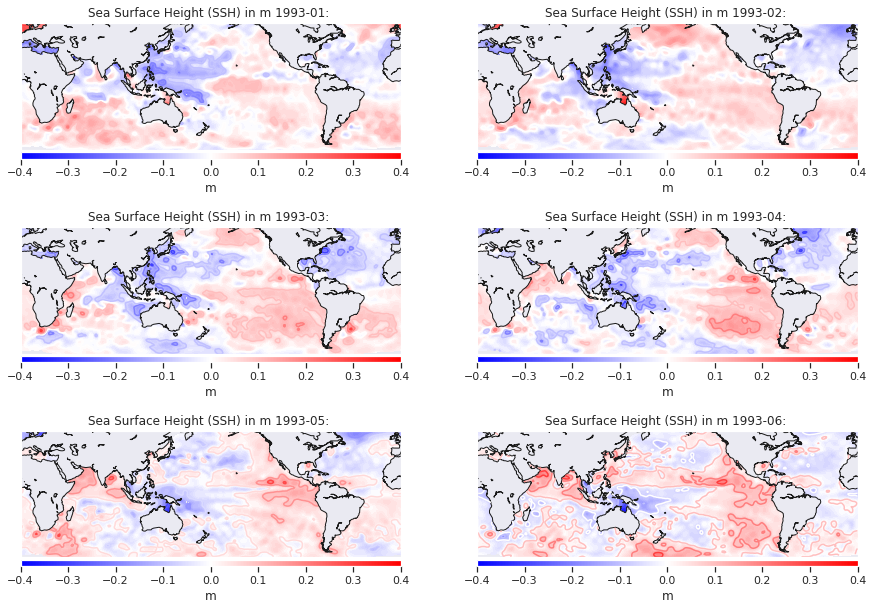

In [8]:
levels = np.arange(-0.4,0.41,0.01)
lon, lat = np.meshgrid(lons, lats)
cmap = plt.cm.bwr
norm = mpl.colors.Normalize(vmin=-0.4, vmax=0.4)

fig, axs = plt.subplots(3, 2, figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

for i,ax in enumerate(axs.ravel()):
    map = Basemap(llcrnrlat=-60, urcrnrlat=60, llcrnrlon=0, urcrnrlon=360,resolution='c',projection="cyl")
    xi, yi = map(lon, lat)
    map.drawcoastlines()
    cs = map.contourf(xi, yi, height_minus_gm[i,:,:]/1000, cmap=cmap, levels=levels, ax=ax)
    cs = map.contour(xi, yi, height_minus_gm[i,:,:]/1000, cmap=cmap, ax=ax)
    #cbar = map.colorbar(cs,location='bottom',pad="15%", ax=ax)
    cbar = map.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), location="bottom", ax=ax)
    cbar.set_label('m')
    ax.set_title("Sea Surface Height (SSH) in m {}: ".format(dates[i]))

## Animations

Animation of the sea level data over time












<IPython.core.display.Javascript object>


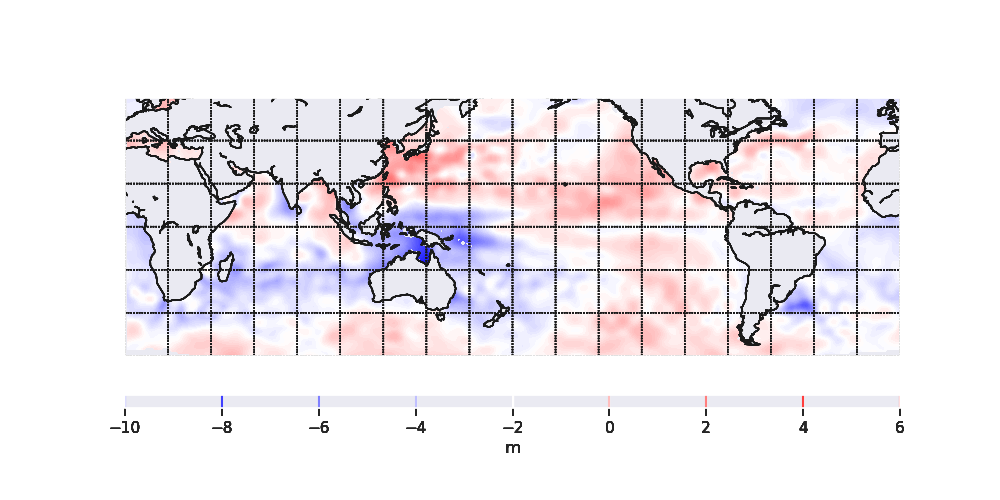

In [15]:
# Animation of the data
%matplotlib notebook
lon, lat = np.meshgrid(lons, lats)
levels = np.arange(-0.4,0.41,0.01)

fig = plt.figure(figsize=(10,5),facecolor='w')
ims = []

#for i in range(len(height[:,0,0])):
for i in range(10):
    Z = height_minus_gm[i,:,:]/1000
    map = Basemap(llcrnrlat=-60, urcrnrlat=60, llcrnrlon=0, urcrnrlon=360,resolution='c',projection="cyl")
    xi, yi = map(lon, lat)
    map.drawcoastlines()
    map.drawparallels(np.arange(-60,60,20.))
    map.drawmeridians(np.arange(0.,360.,20.))
    im = map.contourf(xi, yi, Z, cmap=plt.cm.bwr, levels=levels)
    cbar = map.colorbar(cs,location='bottom',pad="15%")
    cbar.set_label('m')
    ax.set_title("Sea Surface Height (SSH) {}: ".format(dates[i]))
    ims.append(im.collections)

animation = ArtistAnimation(fig,ims,interval=200,repeat=True)
animation;

In [99]:
#animation.save('sl_altimetry19932019.mp4',writer='ffmpeg')
#animation.save('sl_altimetry19932019.gif',writer='imagemagick')

## Plot linear Trend

* Compute the linear trend over the entire time period (01/1993 - 12/2019)
* Plot the linear trend unsing the cylindric projection ("cyl") and the orthogonal projection("ortho")

In [9]:
print("Length of time series: {}".format(len(dates)))

Length of time series: 324


In [10]:
# linear trend over entire time period
y = np.array(height_minus_gm)
X = np.arange(1,len(dates)+1,1).reshape(-1, 1)
trend = np.zeros(shape=(len(lat),len(lon[0])))

for i in range(len(lon[0])):
    for j in range(len(lat)):
        if(np.isnan(y[0,j,i])):
            trend[j,i] = np.nan
        else:
            reg = LinearRegression().fit(X, y[:,j,i])
            trend[j,i] = reg.coef_

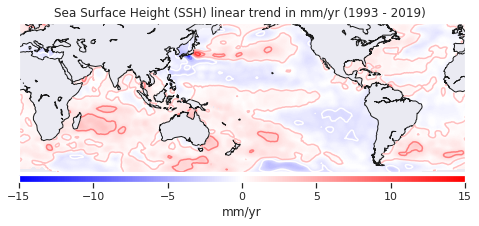

In [11]:
# to get the mean trend per year the regression coefficient has to be multiplied by 12
levels = np.arange(-15,15,0.1)
lon, lat = np.meshgrid(lons, lats)
cmap = plt.cm.bwr
norm = mpl.colors.Normalize(vmin=-15, vmax=15)

fig = plt.figure(figsize=(8,8))

map = Basemap(llcrnrlat=-60, urcrnrlat=60, llcrnrlon=0, urcrnrlon=360,resolution='c',projection="cyl")
xi, yi = map(lon, lat)
map.drawcoastlines()
cs = map.contourf(xi, yi, trend[:,:]*12, cmap=cmap, levels=levels)
cs = map.contour(xi, yi, trend[:,:]*12, cmap=cmap)
#cbar = map.colorbar(cs,location='bottom',pad="15%")
cbar = map.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), location="bottom")
cbar.set_label('mm/yr')
plt.title("Sea Surface Height (SSH) linear trend in mm/yr (1993 - 2019) ");

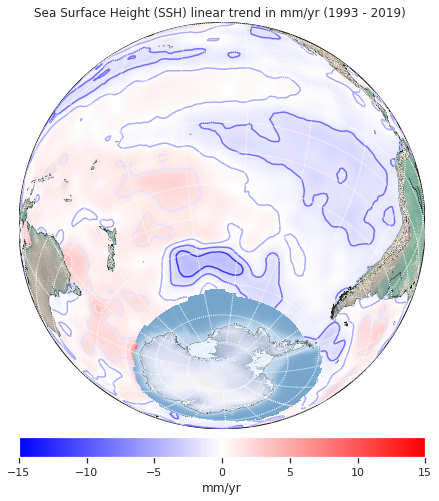

In [15]:
# orthographic map projection 
levels = np.arange(-15,15,0.01)
lon, lat = np.meshgrid(lons, lats)
plt.figure(figsize=(8, 8))

map = Basemap(projection='ortho',lat_0=-45,lon_0=220,resolution='l')
map.drawcoastlines(linewidth=0.25)
map.shadedrelief(scale=0.75)
map.drawparallels(np.linspace(-90, 90, 20), color="white")
map.drawmeridians(np.linspace(0, 360, 20), color="white")
x, y = map(lon, lat)
cs = map.contourf(x,y,trend*12, cmap=cmap, levels=levels)
cs = map.contour(x,y,trend*12,linewidths=1.5, cmap=cmap)
cbar = map.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), location="bottom")
cbar.set_label('mm/yr')
plt.title("Sea Surface Height (SSH) linear trend in mm/yr (1993 - 2019) ");
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


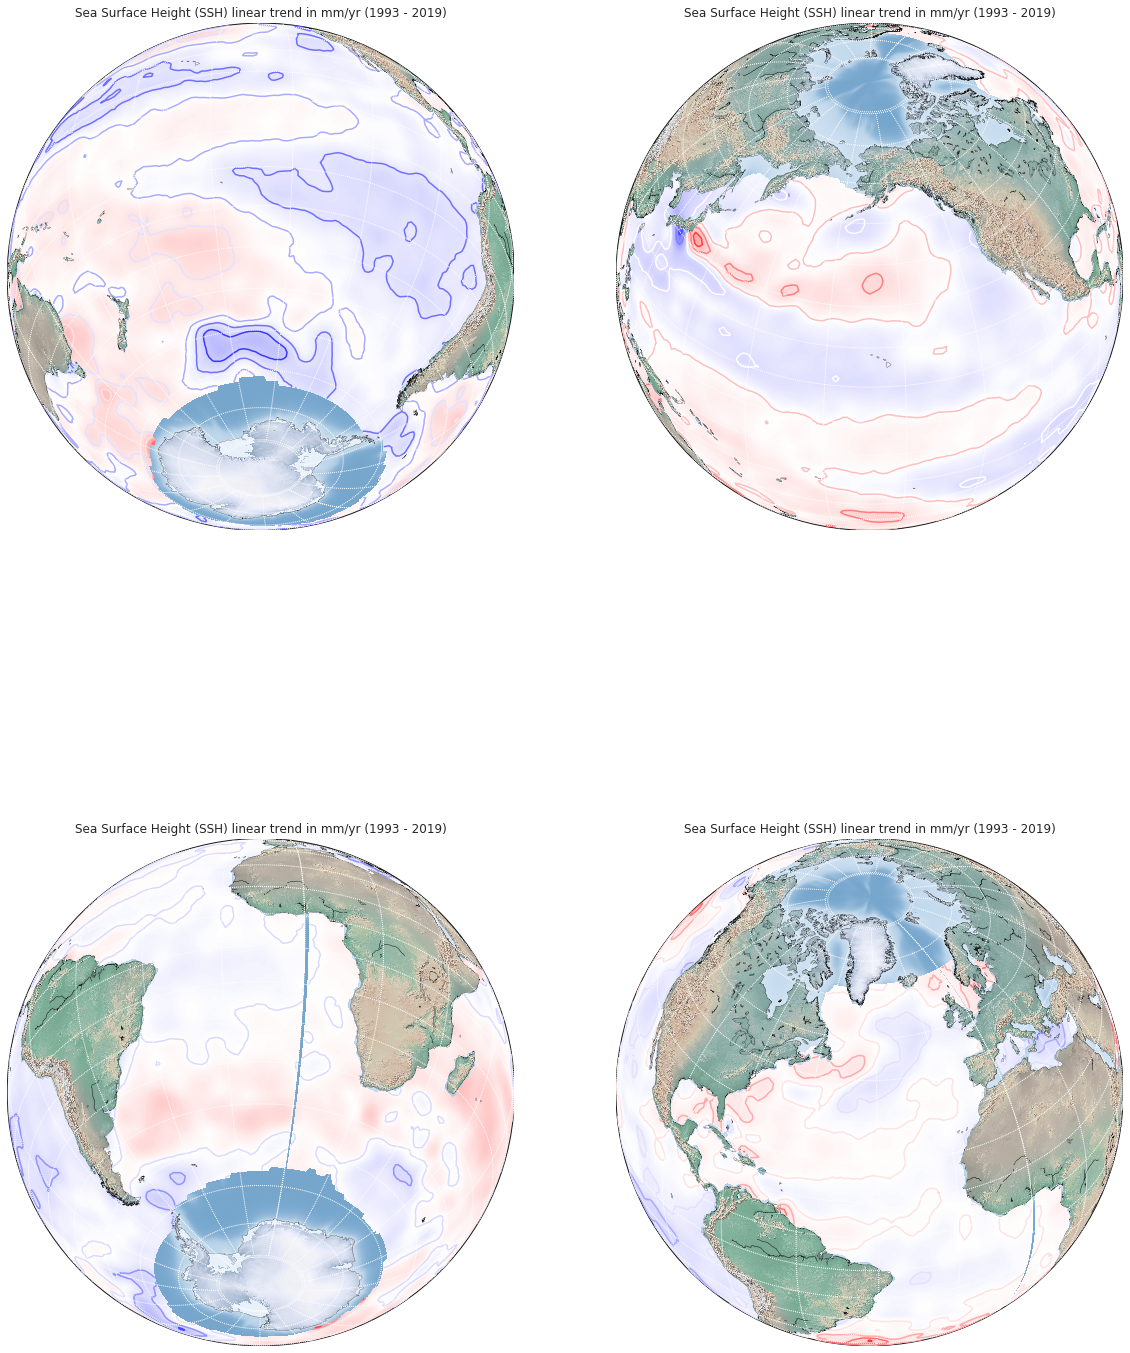

In [15]:
# plot some more perspectives

fig, axs = plt.subplots(2, 2, figsize=(20,25))
plt.subplots_adjust(hspace=0.5)
levels = np.arange(-15,15,0.01)
lon, lat = np.meshgrid(lons, lats)
lat_0 = [-40, 40, -40, 40]
lon_0 = [220, 200, 350, 320]

for i,ax in enumerate(axs.ravel()):
    map = Basemap(resolution='l',lat_0=lat_0[i],lon_0=lon_0[i],projection="ortho")
    map.drawcoastlines(linewidth=0.25, ax=ax)
    map.shadedrelief(scale=0.75, ax=ax)
    map.drawparallels(np.linspace(-90, 90, 20), color="white", ax=ax)
    map.drawmeridians(np.linspace(0, 360, 20), color="white", ax=ax)
    xi, yi = map(lon, lat)
    cs = map.contourf(xi, yi, trend*12, cmap=cmap, levels=levels, ax=ax)
    cs = map.contour(xi, yi, trend*12, cmap=cmap, ax=ax)
    #cbar = map.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), location="bottom", ax=ax)
    #cbar.set_label('mm/yr')
    ax.set_title("Sea Surface Height (SSH) linear trend in mm/yr (1993 - 2019)");

In [12]:
# rotate orthogonal projection
levels = np.arange(-10,10,0.01)
lon, lat = np.meshgrid(lons, lats)
norm = mpl.colors.Normalize(vmin=-10, vmax=10)

ims = []
for i in range(0,350,20):
    fig = plt.figure(figsize=(8, 8))
    map = Basemap(projection='ortho', lat_0=0, lon_0=i, resolution='l', area_thresh=1000.0)
    map.shadedrelief(scale=0.75)
    map.drawparallels(np.linspace(-90, 90, 20), color="white")
    map.drawmeridians(np.linspace(0, 360, 20), color="white")
    xi, yi = map(lon, lat)
    im = map.contourf(xi, yi, trend*12, cmap=plt.cm.bwr, levels=levels)
    im = map.contour(xi, yi, trend*12, cmap=cmap, ax=ax)
    ims.append(im.collections)
    cbar = map.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), location="bottom")
    cbar.set_label('mm/yr')
    plt.title("Sea Surface Height (SSH) linear trend in mm/yr (1993 - 2019) ");
    name = str(i)
    path = "images/" + name
    plt.savefig(path+'.png')
    plt.close()

!convert -delay 100 -loop 0 images/*.png trends19932019_rotate.gif

## Global mean Sea Level

The dataset also provides the global mean sea level for the altimetry period. Plot it and its linear trend.

In [107]:
# test if mean of gmsl is 0
print(np.mean(gmsl))

<xarray.Variable ()>
array(0.00925926)


In [115]:
# linear trend
y = np.array(gmsl)
X = np.arange(1,len(dates)+1,1).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
trend_gmsl = reg.coef_
intercept = reg.intercept_
print("Regression line: {}x + ({})".format(round(trend_gmsl[0],2),round(intercept,2)))

Regression line: 0.27x + (-43.16)


Trend line:
y= 0.27 x+( -43.16)
To get the mean trend per year, the regression coefficient has to be multiplied by 12:
Mean Trend 3.19 mm/yr:


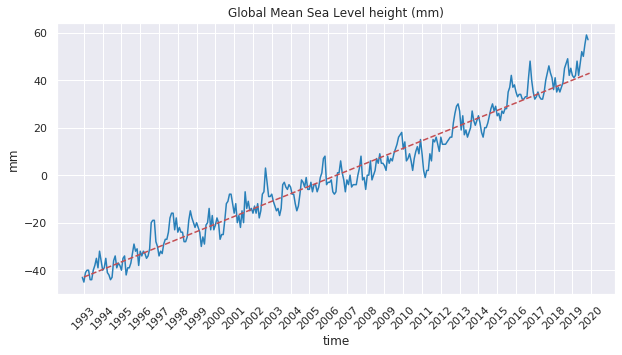

In [120]:
# global mean sea level
labels = np.arange(1,28*12+1,12)
time1 = np.arange(1993,2021,1)
x = np.linspace(1,324,324)

fig = plt.figure(figsize=(10,5))#,facecolor='w')
plt.plot(gmsl-np.mean(gmsl), color="#2980b9")
plt.plot(x,trend_gmsl[0]*x+intercept,"r--")
# the line equation:
print("Trend line:")
print("y= {} x+( {})".format(round(trend_gmsl[0],2),round(intercept,2)))
plt.xlabel("time")
plt.ylabel("mm")
plt.title("Global Mean Sea Level height (mm)")
plt.xticks(labels, time1, rotation=45);
print("To get the mean trend per year, the regression coefficient has to be multiplied by 12:")
print("Mean Trend {} mm/yr:".format(round(trend_gmsl[0]*12,2)))